<a href="https://colab.research.google.com/github/niklasfaller/DIS21-BIg-Data/blob/main/Ex12_Using_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">

# 12th exercise: <font color="#C70039">Using recurrent neural networks</font>
* Course: DIS21a.1
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook modifications and adaptations: Niklas Faller
* Date:   21.01.2024

<img src="https://www.knime.com/sites/default/files/fig_1_3.png" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information about your tasks (e.g. regarding the set of certain paramaters or specific computational tricks, etc.), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation (for instance, after you have run through your test plan) you may use German language.
This applies to all exercises in DIS 21a.1.  

---------------------

### <font color="ce33ff">DESCRIPTION</font>:

This notebook allows for learning how to setup and use a Recurrent Neural Network (RNN). So let's go for it.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
Within this notebook, the tasks that you need to work on are always listed as bullet points below.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook before submitting it.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully.
    * add comments whereever you feel it necessary for better understanding.
    * run the notebook and try to follow and understand all steps and examples.
4. at the end of PART II, interprete the two charts (training and validation accuracy) and (training and validation loss) and describe your findings.
5. the exercise in this notebook contains in PART III one single implementational task.
    * implement a Gated Recurrent Unit (GRU) by yourself using Keras' built-in functions.
        * use the same training and validation data set
        * use a history object
        * plot the results of the training and validation accuracy and loss, respectively.
    * let yourself be guided from the other examples in this notebook.
-----------------------------------------------------------------------------------

## START OF THE NOTEBOOK CODE
---------------------------------------------------

## <font color="#C70039">PART I</font>
### Getting started with RNNs
#### A first recurrent layer in Keras

In [1]:
import tensorflow
#tensorflow.keras.__version__

The process in exercise 11 that was naively implemented in numpy corresponds to an actual Keras layer: the `SimpleRNN` layer.
`SimpleRNN` processes batches of sequences, like all the other Keras layers do, and not just a single sequence like
in the numpy implementation example of exercise 11. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.

As all recurrent layers in Keras, `SimpleRNN` can be run in two different modes. It can either

* return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`)

or

* return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument.

Let us take a look at an example.

In [2]:
from tensorflow.keras.layers import SimpleRNN

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322080 (1.23 MB)
Trainable params: 322080 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network.
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328320 (1.25 MB)
Trainable params: 328320 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now, try to use such a model on the IMDB movie review classification problem.

Step1: preprocess the data

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let us train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [7]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 26s 156ms/step - loss: 0.5986 - acc: 0.6647 - val_loss: 0.5191 - val_acc: 0.7416
Epoch 2/10
157/157 [==============================] - 22s 137ms/step - loss: 0.3750 - acc: 0.8436 - val_loss: 0.4027 - val_acc: 0.8202
Epoch 3/10
157/157 [==============================] - 23s 144ms/step - loss: 0.2921 - acc: 0.8849 - val_loss: 0.3640 - val_acc: 0.8384
Epoch 4/10
157/157 [==============================] - 23s 146ms/step - loss: 0.2507 - acc: 0.9074 - val_loss: 0.3444 - val_acc: 0.8572
Epoch 5/10
157/157 [==============================] - 22s 140ms/step - loss: 0.2065 - acc: 0.9242 - val_loss: 0.3574 - val_acc: 0.8650
Epoch 6/10
157/157 [==============================] - 22s 143ms/step - loss: 0.1752 - acc: 0.9365 - val_loss: 0.3641 - val_acc: 0.8622
Epoch 7/10
157/157 [==============================] - 23s 150ms/step - loss: 0.1277 - acc: 0.9550 - val_loss: 0.3929 - val_acc: 0.8572
Epoch 8/10
157/157 [==============================] - 2

Let us display the training and validation loss and accuracy:

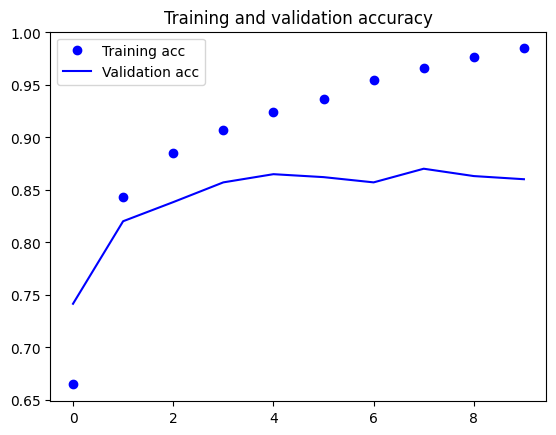

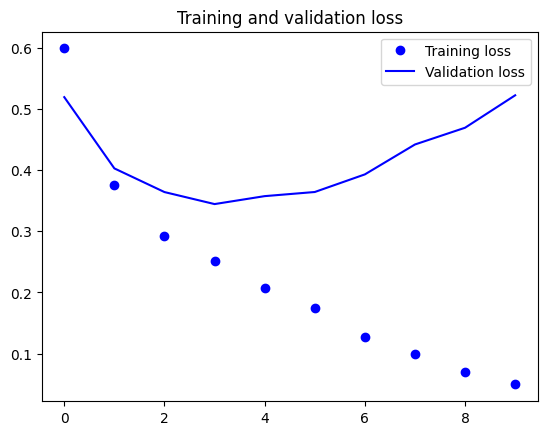

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Remember that in the first IMDB exercise, the first naive approach reached up to 88% test accuracy (baseline). Unfortunately, this simple RNN does not perform very well at all compared to that baseline since it only reached to 85% validation accuracy. So why is this?

On the one hand, part of the problem is that the inputs only consider the first 500 words rather the full sequences.  
Hence the RNN has got access to less information than the earlier baseline model (please compare).

On the other hand the problem is simply that `SimpleRNN` is not very good at processing long sequences, like text.
Other types of recurrent layers perform much better such as LSTM and GRU which you have learned in the lecture course.

## <font color="#C70039">PART II</font>

### LSTM example implementation in Keras

Now, for the above mentioned reasons it makes sense to set up a model using a LSTM layer and train it on the very same IMDB data.

<font color="#C70039">NOTE:</font> The network is quite similar to the one with SimpleRNN from Part I above.

Only specify the output dimensionality of the LSTM layer, and leave every other argument to the Keras defaults. Keras has got good defaults and things will almost always just work without you having to spend time tuning parameters by hand.

In [9]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 51s 312ms/step - loss: 0.5878 - acc: 0.6775 - val_loss: 0.4368 - val_acc: 0.7974
Epoch 2/10
157/157 [==============================] - 47s 296ms/step - loss: 0.3493 - acc: 0.8579 - val_loss: 0.3244 - val_acc: 0.8674
Epoch 3/10
157/157 [==============================] - 48s 305ms/step - loss: 0.2695 - acc: 0.8950 - val_loss: 0.3623 - val_acc: 0.8416
Epoch 4/10
157/157 [==============================] - 46s 295ms/step - loss: 0.2318 - acc: 0.9114 - val_loss: 0.3360 - val_acc: 0.8566
Epoch 5/10
157/157 [==============================] - 48s 303ms/step - loss: 0.2042 - acc: 0.9272 - val_loss: 0.3578 - val_acc: 0.8662
Epoch 6/10
157/157 [==============================] - 46s 296ms/step - loss: 0.1848 - acc: 0.9317 - val_loss: 0.3096 - val_acc: 0.8854
Epoch 7/10
157/157 [==============================] - 48s 304ms/step - loss: 0.1683 - acc: 0.9401 - val_loss: 0.3139 - val_acc: 0.8694
Epoch 8/10
157/157 [==============================] - 4

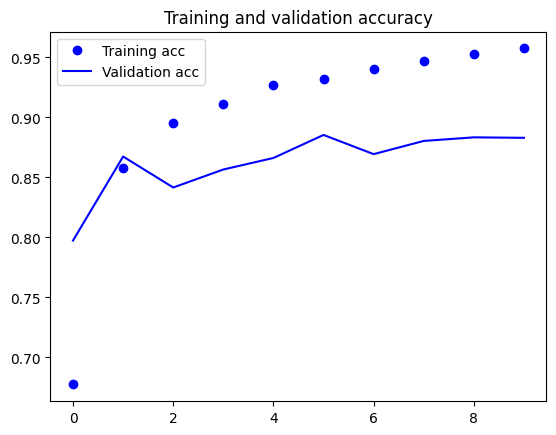

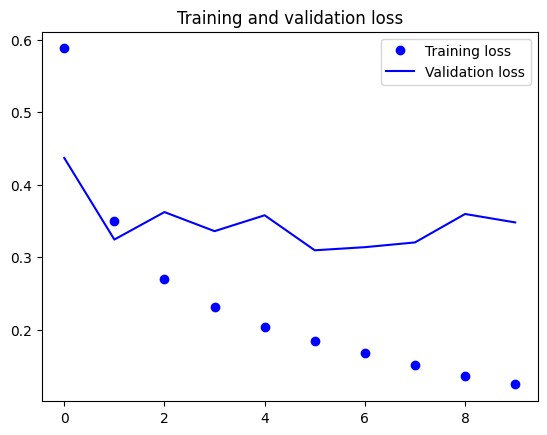

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<font color="ce33ff">Your TASK</font>


Die Training Acc nimmt sehr stark zu und das Modell beginnt früh zu overfitten, während die Validation acc zu Beginn schon hoch ist und dann nahezu stagniert.

Training loss sinkt schnell ab und dann immer weniger wobei es dann zu overfitting kommen kann.

----------------
## <font color="#C70039">PART III</font>

### GRU example implementation in Keras

In [11]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 47s 285ms/step - loss: 0.6161 - acc: 0.6444 - val_loss: 0.4184 - val_acc: 0.8078
Epoch 2/10
157/157 [==============================] - 47s 297ms/step - loss: 0.3601 - acc: 0.8451 - val_loss: 0.3628 - val_acc: 0.8412
Epoch 3/10
157/157 [==============================] - 44s 279ms/step - loss: 0.2856 - acc: 0.8846 - val_loss: 0.3374 - val_acc: 0.8600
Epoch 4/10
157/157 [==============================] - 44s 279ms/step - loss: 0.2421 - acc: 0.9059 - val_loss: 0.4011 - val_acc: 0.8364
Epoch 5/10
157/157 [==============================] - 47s 299ms/step - loss: 0.2122 - acc: 0.9196 - val_loss: 0.3229 - val_acc: 0.8786
Epoch 6/10
157/157 [==============================] - 44s 278ms/step - loss: 0.1932 - acc: 0.9278 - val_loss: 0.3679 - val_acc: 0.8736
Epoch 7/10
157/157 [==============================] - 44s 279ms/step - loss: 0.1784 - acc: 0.9343 - val_loss: 0.4779 - val_acc: 0.8224
Epoch 8/10
157/157 [==============================] - 4

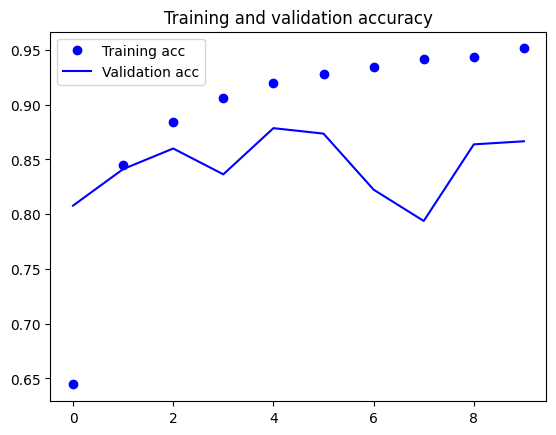

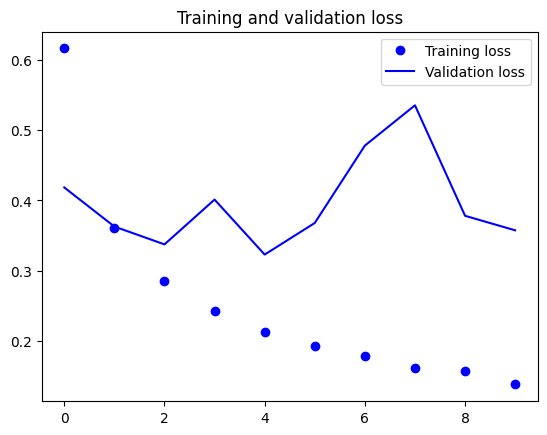

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)
Epoch 1/10
625/625 [==============================] - 102s 159ms/step - loss: 0.4969 - acc: 0.7434 - val_loss: 0.3905 - val_acc: 0.8296
Epoch 2/10
625/625 [==============================] - 98s 157ms/step - loss: 0.3021 - acc: 0.8782 - val_loss: 0.3088 - val_acc: 0.8726
Epoch 3/10
625/625 [==============================] - 94s 151ms/step - loss: 0.2451 - acc: 0.9047 - val_loss: 0.2843 - val_acc: 0.8886
Epoch 4/10
625/625 [==============================] - 94s 150ms/step - loss: 0.2078 - acc: 0.9220 - val_loss: 0.2964 - val_acc: 0.8802
Epoch 5/10
625/625 [==============================] - 96s 153ms/step - loss: 0.1859 - acc: 0.9314 - val_loss: 0.3316 - val_acc: 0.8774
Epoch 6/10
625/625 [==============================] - 102s 163ms/step - loss: 0.1655 - acc: 0.9408 - val_loss: 0.2915 - val_acc: 0.8946
Epoch 7/10
625/625 [=======================

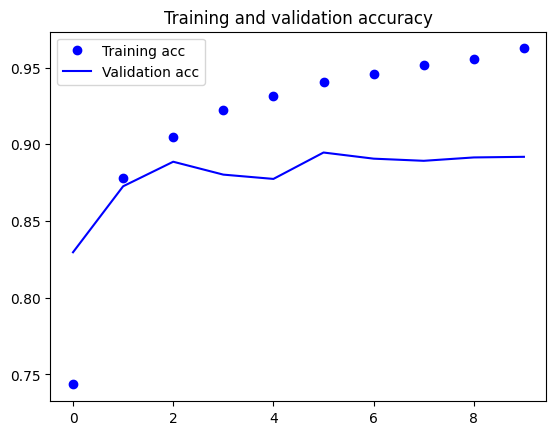

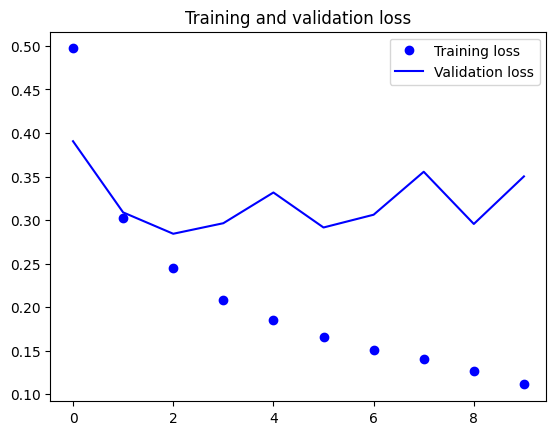

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt

# Laden der IMDb-Daten
max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

# Padding der Sequenzen
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Erstellen des GRU-Modells
model_gru = Sequential()
model_gru.add(Embedding(max_features, 32))
model_gru.add(GRU(32))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Trainieren des GRU-Modells
history_gru = model_gru.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot der Trainings- und Validierungsgenauigkeit
acc = history_gru.history['acc']
val_acc = history_gru.history['val_acc']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
